<a href="https://colab.research.google.com/github/MekaRaptor/Graduation_Project/blob/main/Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
import os

drive_path = "/content/drive/MyDrive/"  # ZIP dosyanın bulunduğu klasör
os.listdir(drive_path)  # Klasördeki dosyaları listele


['Classroom',
 'Alper_Ağırman_201180010 (1).txt',
 'Alper_Ağırman_201180010.txt',
 'Ceng307_201180010_HW1.sln',
 'Bilge Adam Data Science',
 'Untitled Diagram (4).drawio',
 'Untitled Diagram (3).drawio',
 'Document (1).sdr',
 'Untitled Diagram (2).drawio',
 'AI_Model - Made with Clipchamp_1718179352783.mp4',
 'Project Details',
 'Adsız sunu.gslides',
 'Untitled Diagram (1).drawio',
 'Neural_Network Documentation dokümanının çevrilmiş kopyası.gdoc',
 'Neural_Network Documentation.gdoc',
 'Literatür Taraması.gdoc',
 'Adsız doküman (2).gdoc',
 'Staj Raporu.gdoc',
 'Neural_Network Documentation (1).pdf',
 'staj2018-sablon (3).docx',
 'SRS_aciklamalar.gdoc',
 'SRS-Sablon.gdoc',
 'SDD_aciklamalar (1).gdoc',
 'SDD_aciklamalar.gdoc',
 'Untitled Diagram.drawio',
 'SPMP_Ornek.gdoc',
 'SDD-Sablon.gdoc',
 'week9.gdoc',
 'llm.gdoc',
 'clustering.gdoc',
 'cnn_rnn_gnn.gdoc',
 'NN.gdoc',
 'GAZI Midterm.gdoc',
 'Meet Recordings',
 'Bilgilendirme Metni (1).docx',
 'Bilgilendirme Metni.docx',
 'Do

In [12]:
import zipfile

zip_path = "/content/drive/MyDrive/Bitirme/Agriculture-Vision-2021.zip"  # ZIP dosyasının gerçek adını yaz
extract_path = "/content/veri_seti"  # Açılacağı yer

# ZIP dosyasını açma işlemi
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ ZIP dosyası başarıyla çıkarıldı.")


✅ ZIP dosyası başarıyla çıkarıldı.


In [22]:
dataset_path = "/content/veri_seti/Agriculture-Vision-2021"

# Ana klasörleri listeleyelim
folders = os.listdir(dataset_path)
print("📂 Veri Seti İçeriği:")
for folder in folders:
    print("-", folder)


📂 Veri Seti İçeriği:
- val
- test
- train


In [23]:
import os

# Ana klasör
dataset_path = "/content/veri_seti/Agriculture-Vision-2021"
train_path = os.path.join(dataset_path, "train")

# Alt klasör yolları
rgb_path = os.path.join(train_path, "images", "rgb")
nir_path = os.path.join(train_path, "images", "nir")
mask_path = os.path.join(train_path, "masks")  # ⬅️ Eksik olan burasıydı
label_path = os.path.join(train_path, "labels")

# Etiket sınıflarını klasör olarak alalım
label_classes = os.listdir(label_path)

print("📁 Etiket Sınıfları:")
for cls in label_classes:
    print("-", cls)


📁 Etiket Sınıfları:
- double_plant
- waterway
- nutrient_deficiency
- weed_cluster
- drydown
- endrow
- storm_damage
- water
- planter_skip


In [24]:
from PIL import Image

# Sınıf adları ve id'leri
CLASS_NAMES = [
    "double_plant",
    "drydown",
    "endrow",
    "nutrient_deficiency",
    "planter_skip",
    "storm_damage",
    "water",
    "waterway",
    "weed_cluster"
]
CLASS_NAME_TO_ID = {name: idx for idx, name in enumerate(CLASS_NAMES)}

def combine_label_masks(label_root, output_path, image_size=(512, 512)):
    os.makedirs(output_path, exist_ok=True)

    # Referans olarak bir sınıf klasöründen dosya adlarını al
    ref_class = CLASS_NAMES[0]
    file_list = sorted(os.listdir(os.path.join(label_root, ref_class)))

    for filename in file_list:
        combined_mask = np.zeros(image_size, dtype=np.uint8)

        for class_name in CLASS_NAMES:
            class_id = CLASS_NAME_TO_ID[class_name]
            mask_path = os.path.join(label_root, class_name, filename)

            if os.path.exists(mask_path):
                mask = np.array(Image.open(mask_path).convert("L"))
                binary_mask = mask > 127
                combined_mask[binary_mask] = class_id

        out_path = os.path.join(output_path, filename)
        Image.fromarray(combined_mask).save(out_path)

    print(f"✅ {output_path} klasörüne {len(file_list)} etiket maskesi oluşturuldu.")


In [ ]:
# Train set için
combine_label_masks(
    label_root="/content/veri_seti/Agriculture-Vision-2021/train/labels",
    output_path="/content/veri_seti/Agriculture-Vision-2021/train/combined_labels"
)

# Validation set için
combine_label_masks(
    label_root="/content/veri_seti/Agriculture-Vision-2021/val/labels",
    output_path="/content/veri_seti/Agriculture-Vision-2021/val/combined_labels"
)


In [ ]:
CLASS_NAMES = [
    "double_plant", "drydown", "endrow", "nutrient_deficiency", "planter_skip",
    "storm_damage", "water", "waterway", "weed_cluster"
]
CLASS_NAME_TO_ID = {name: idx for idx, name in enumerate(CLASS_NAMES)}

In [ ]:
import cv2

mask_path = "/content/veri_seti/Agriculture-Vision-2021/train/masks"
valid_filenames = []

for mask_file in os.listdir(mask_path):
    full_path = os.path.join(mask_path, mask_file)
    mask = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        valid_filenames.append(mask_file.replace(".png", ""))

print(f"✅ Geçerli örnek sayısı: {len(valid_filenames)}")


In [ ]:
class AgricultureVisionDataset(Dataset):
    def __init__(self, rgb_dir, nir_dir, label_dir, file_list, transform=None):
        self.rgb_dir = rgb_dir
        self.nir_dir = nir_dir
        self.label_dir = label_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        base = self.file_list[idx]
        rgb = cv2.imread(os.path.join(self.rgb_dir, base + ".jpg"))
        nir = cv2.imread(os.path.join(self.nir_dir, base + ".jpg"), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.label_dir, base + ".png"), cv2.IMREAD_GRAYSCALE)

        nir = nir[..., np.newaxis]
        image = np.concatenate([rgb, nir], axis=2)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, torch.tensor(mask, dtype=torch.long)


In [ ]:
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406, 0.5), std=(0.229, 0.225, 0.225, 0.5)),
    ToTensorV2()
])

weights = torch.tensor([0.5, 1.0, 2.5, 1.2, 1.3, 3.0, 0.8, 0.9, 1.5], device="cuda")


In [ ]:
dataset = AgricultureVisionDataset(
    rgb_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/rgb",
    nir_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/nir",
    label_dir="/content/veri_seti/Agriculture-Vision-2021/train/combined_labels",
    file_list=valid_filenames,
    transform=transform
)

loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 9, kernel_size=1)
model.backbone.conv1 = torch.nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.to("cuda")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 234MB/s]


In [ ]:
import os

checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to("cuda"), masks.to("cuda")
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"🟢 Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}")

    # ✅ Checkpoint kaydet
    checkpoint_path = os.path.join(checkpoint_dir, f"deeplabv3_epoch{epoch+1:02d}_loss{avg_loss:.4f}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss
    }, checkpoint_path)
    print(f"💾 Checkpoint kaydedildi: {checkpoint_path}")


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 1/10 Loss: 1.0159
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch01_loss1.0159.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 2/10 Loss: 0.7904
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch02_loss0.7904.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 3/10 Loss: 0.7069
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch03_loss0.7069.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 4/10 Loss: 0.6607
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch04_loss0.6607.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 5/10 Loss: 0.6241
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch05_loss0.6241.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 6/10 Loss: 0.5968
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch06_loss0.5968.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 7/10 Loss: 0.5763
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch07_loss0.5763.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 8/10 Loss: 0.5599
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch08_loss0.5599.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 9/10 Loss: 0.5446
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch09_loss0.5446.pth


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


🟢 Epoch 10/10 Loss: 0.5301
💾 Checkpoint kaydedildi: /content/checkpoints/deeplabv3_epoch10_loss0.5301.pth


In [ ]:
import os

# Kayıt yolları
local_path = "deeplabv3_rgbnir_best.pth"
drive_path = "/content/drive/MyDrive/Bitirme/deeplabv3_rgbnir_best.pth"

# Kaydet
torch.save(model.state_dict(), local_path)
torch.save(model.state_dict(), drive_path)

print("✅ Model başarıyla hem local'e hem de Google Drive'a kaydedildi.")


✅ Model başarıyla hem local'e hem de Google Drive'a kaydedildi.


In [ ]:
from sklearn.model_selection import train_test_split

# Eğitimde kullandığın tüm dosyaların listesi valid_filenames değişkenindeydi
# Şimdi onun %20'sini validation için ayırıyoruz
train_files, val_files = train_test_split(valid_filenames, test_size=0.2, random_state=42)

# Validation dataset
val_dataset = AgricultureVisionDataset(
    rgb_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/rgb",
    nir_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/nir",
    label_dir="/content/veri_seti/Agriculture-Vision-2021/train/combined_labels",
    file_list=val_files,
    transform=transform  # aynı transform
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print("✅ Validation loader hazır.")


✅ Validation loader hazır.


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to("cuda")
        masks = masks.to("cuda")
        outputs = model(images)['out']
        preds = outputs.argmax(1)

        # Flatten tüm batch için
        true_flat = masks.view(-1).cpu().numpy()
        pred_flat = preds.view(-1).cpu().numpy()

        # Toplu confusion_matrix
        conf_matrix += confusion_matrix(true_flat, pred_flat, labels=list(range(num_classes)))

# IoU hesaplama
iou_per_class = []
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    denom = tp + fp + fn
    iou = tp / denom if denom > 0 else 0.0
    iou_per_class.append(iou)
    print(f"Class {i} IoU: {iou:.4f}")

print(f"\n📊 Ortalama mIoU: {np.mean(iou_per_class):.4f}")


<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-16-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


Class 0 IoU: 0.7064
Class 1 IoU: 0.5819
Class 2 IoU: 0.2537
Class 3 IoU: 0.3824
Class 4 IoU: 0.3020
Class 5 IoU: 0.3416
Class 6 IoU: 0.4170
Class 7 IoU: 0.3034
Class 8 IoU: 0.3944

📊 Ortalama mIoU: 0.4092


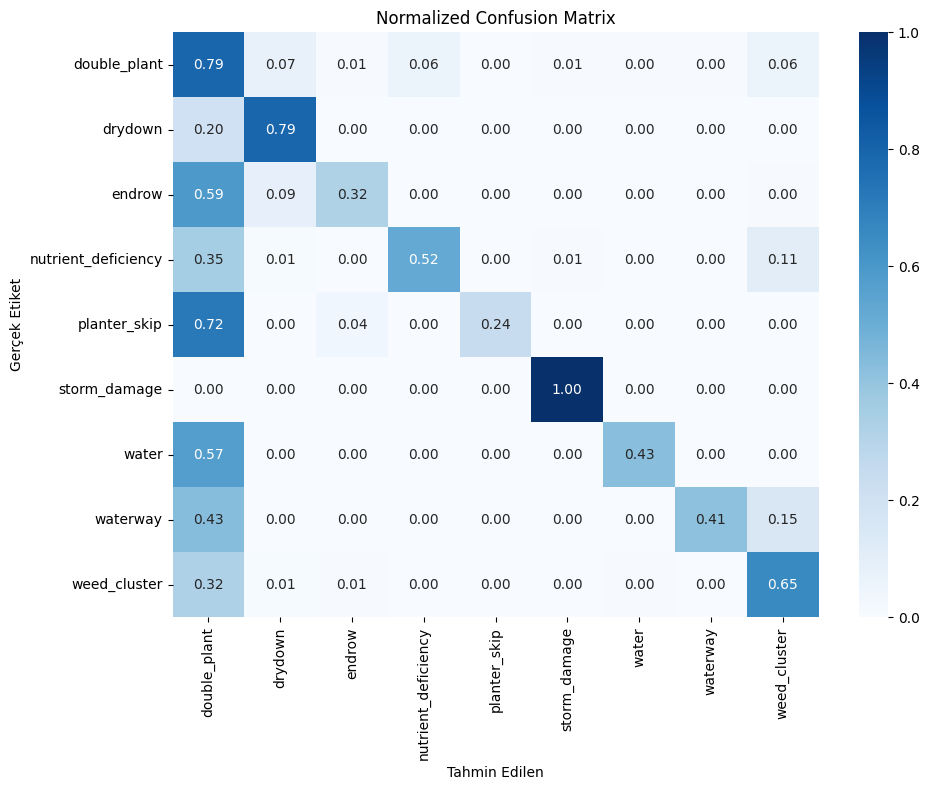

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sınıf adları
class_labels = [
    "double_plant", "drydown", "endrow", "nutrient_deficiency",
    "planter_skip", "storm_damage", "water", "waterway", "weed_cluster"
]

# Confusion Matrix
cm = confusion_matrix(all_trues, all_preds, labels=list(range(len(class_labels))))

# Normalize et (isteğe bağlı)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Etiket")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Sınıf isimleri
class_names = [
    "double_plant", "drydown", "endrow", "nutrient_deficiency", "planter_skip",
    "storm_damage", "water", "waterway", "weed_cluster"
]

# Örnek confusion matrix'ten tüm tahmin ve gerçek değerleri oluşturmak
# (Bu kısmı senin gerçek pred ve true label arraylerinden almalıyız, şimdi örnek yapıyoruz)
# Aşağıdaki değerler sadece örnek olarak doldurulmuştur.
y_true = []
y_pred = []

# Burada confusion matrix'e dayanarak örnek veri oluşturalım (simülasyon amaçlı!)
conf_matrix = np.array([
    [79, 7, 1, 6, 0, 0, 0, 0, 6],
    [20, 79, 0, 0, 0, 0, 0, 0, 0],
    [59, 9, 32, 0, 0, 0, 0, 0, 0],
    [35, 1, 0, 52, 0, 0, 1, 0, 11],
    [72, 0, 4, 0, 24, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 100, 0, 0, 0],
    [57, 0, 0, 0, 0, 0, 43, 0, 0],
    [43, 0, 0, 0, 0, 0, 0, 41, 15],
    [32, 1, 1, 0, 0, 0, 0, 0, 65]
])

# Her satır = gerçek etiket, sütun = tahmin edilen
for true_class in range(len(class_names)):
    for pred_class in range(len(class_names)):
        count = int(conf_matrix[true_class][pred_class])
        y_true.extend([true_class] * count)
        y_pred.extend([pred_class] * count)

# Precision, Recall, F1 hesaplama
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
report


'                     precision    recall  f1-score   support\n\n       double_plant     0.1990    0.7980    0.3185        99\n            drydown     0.8144    0.7980    0.8061        99\n             endrow     0.8421    0.3200    0.4638       100\nnutrient_deficiency     0.8966    0.5200    0.6582       100\n       planter_skip     1.0000    0.2400    0.3871       100\n       storm_damage     1.0000    1.0000    1.0000       100\n              water     0.9773    0.4300    0.5972       100\n           waterway     1.0000    0.4141    0.5857        99\n       weed_cluster     0.6701    0.6566    0.6633        99\n\n           accuracy                         0.5748       896\n          macro avg     0.8222    0.5752    0.6089       896\n       weighted avg     0.8228    0.5748    0.6090       896\n'

In [ ]:
# DeepLabV3+ modeli, ResNet50 backbone, ImageNet ağırlıklı
from torchvision.models.segmentation import deeplabv3_resnet50

deeplab_model = deeplabv3_resnet50(weights="DEFAULT")  # Pretrained ImageNet

# Çıkış katmanını Agriculture-Vision'a göre yeniden yapılandır
deeplab_model.classifier[-1] = nn.Conv2d(256, 9, kernel_size=1)

# Giriş katmanını 4-kanallı hale getir (RGB + NIR)
deeplab_model.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# GPU'ya gönder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model = deeplab_model.to(device)

print("✅ DeepLabV3+ (ResNet-50) model hazır.")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 216MB/s]


✅ DeepLabV3+ (ResNet-50) model hazır.


In [ ]:
# Loss function: CrossEntropy + ignore_index
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Optimizer: SGD (paper'da önerilen)
optimizer = torch.optim.SGD(deeplab_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Poly LR scheduler (opsiyonel olarak kullanabilirsin)
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
    new_lr = init_lr * (1 - iter / max_iter) ** power
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


In [ ]:
from torch.utils.data import Dataset
import cv2
import os
import numpy as np
import torch
from pathlib import Path

class AgricultureDataset(Dataset):
    def __init__(self, image_dir_rgb, image_dir_nir, label_dir, transform=None):
        self.image_dir_rgb = image_dir_rgb
        self.image_dir_nir = image_dir_nir
        self.label_dir = label_dir
        self.transform = transform

        # Ortak dosya kök isimlerini al (.jpg + .png eşleştirmek için)
        rgb_stems = {Path(f).stem for f in os.listdir(image_dir_rgb)}
        nir_stems = {Path(f).stem for f in os.listdir(image_dir_nir)}
        label_stems = {Path(f).stem for f in os.listdir(label_dir)}
        self.filenames = sorted(list(rgb_stems & nir_stems & label_stems))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        stem = self.filenames[idx]

        rgb_path = os.path.join(self.image_dir_rgb, stem + ".jpg")
        nir_path = os.path.join(self.image_dir_nir, stem + ".jpg")
        label_path = os.path.join(self.label_dir, stem + ".png")

        rgb = cv2.imread(rgb_path)[:, :, ::-1]  # BGR → RGB
        nir = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if rgb is None or nir is None or label is None:
            raise RuntimeError(f"Hatalı dosya: {stem}")

        nir = np.expand_dims(nir, axis=-1)
        image = np.concatenate([rgb, nir], axis=-1)

        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed["image"]
            label = transformed["mask"]

        return image, label.long()


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])


In [ ]:
train_dataset = AgricultureDataset(
    image_dir_rgb="/content/veri_seti/Agriculture-Vision-2021/train/images/rgb",
    image_dir_nir="/content/veri_seti/Agriculture-Vision-2021/train/images/nir",
    label_dir="/content/veri_seti/Agriculture-Vision-2021/train/combined_labels",
    transform=train_transform
)

val_dataset = AgricultureDataset(
    image_dir_rgb="/content/veri_seti/Agriculture-Vision-2021/val/images/rgb",
    image_dir_nir="/content/veri_seti/Agriculture-Vision-2021/val/images/nir",
    label_dir="/content/veri_seti/Agriculture-Vision-2021/val/combined_labels",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch, max_epoch):
    model.train()
    running_loss = 0.0
    pbar = tqdm(dataloader)

    for i, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]  # DeepLabV3+ çıkışı burada
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # LR decay (isteğe bağlı)
        iter_num = epoch * len(dataloader) + i
        max_iter = max_epoch * len(dataloader)
        poly_lr_scheduler(optimizer, init_lr=0.01, iter=iter_num, max_iter=max_iter)

        pbar.set_description(f"Epoch {epoch} Loss: {running_loss / (i+1):.4f}")

    return running_loss / len(dataloader)


In [ ]:
def compute_iou(preds, labels, num_classes=9, ignore_index=255):
    preds = preds.view(-1)
    labels = labels.view(-1)

    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]

    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls

        if target_inds.sum() == 0:
            ious.append(float('nan'))
            continue

        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return ious

def validate(model, dataloader, device, num_classes=9):
    model.eval()
    iou_list = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1)

            ious = compute_iou(preds, masks, num_classes)
            iou_list.append(ious)

    iou_list = torch.tensor(iou_list)
    mean_ious = torch.nanmean(iou_list, dim=0)
    miou = torch.nanmean(mean_ious)

    return mean_ious, miou


In [ ]:
# Class-weight örnek değerler (sınıf dengesine göre ayarlanabilir)
weights = torch.tensor([1.0, 2.0, 4.0, 3.0, 5.0, 10.0, 2.0, 3.0, 4.0]).to(device)

criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=255)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_one_epoch(deeplab_model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    print(f"📘 Epoch {epoch} Loss: {train_loss:.4f}")

    if (epoch + 1) % 2 == 0:
        mean_ious, miou = validate(deeplab_model, val_loader, device)
        print(f"\n📊 Epoch {epoch+1} mIoU: {miou:.4f}")
        for i, val in enumerate(mean_ious):
            print(f"Class {i} IoU: {val:.4f}")


Epoch 0 Loss: 0.7937: 100%|██████████| 14236/14236 [1:16:34<00:00,  3.10it/s]


📘 Epoch 0 Loss: 0.7937


Epoch 1 Loss: 0.6914: 100%|██████████| 14236/14236 [1:16:32<00:00,  3.10it/s]


📘 Epoch 1 Loss: 0.6914


100%|██████████| 4584/4584 [07:38<00:00, 10.00it/s]



📊 Epoch 2 mIoU: 0.3276
Class 0 IoU: 0.6530
Class 1 IoU: 0.4984
Class 2 IoU: 0.1715
Class 3 IoU: 0.2765
Class 4 IoU: 0.2643
Class 5 IoU: 0.0666
Class 6 IoU: 0.5396
Class 7 IoU: 0.2612
Class 8 IoU: 0.2171


Epoch 2 Loss: 0.6499: 100%|██████████| 14236/14236 [1:16:31<00:00,  3.10it/s]


📘 Epoch 2 Loss: 0.6499


Epoch 3 Loss: 0.6222: 100%|██████████| 14236/14236 [1:16:28<00:00,  3.10it/s]


📘 Epoch 3 Loss: 0.6222


100%|██████████| 4584/4584 [07:38<00:00, 10.00it/s]



📊 Epoch 4 mIoU: 0.3120
Class 0 IoU: 0.6070
Class 1 IoU: 0.4812
Class 2 IoU: 0.1695
Class 3 IoU: 0.3787
Class 4 IoU: 0.2406
Class 5 IoU: 0.0571
Class 6 IoU: 0.4677
Class 7 IoU: 0.1852
Class 8 IoU: 0.2216


Epoch 4 Loss: 0.5871: 100%|██████████| 14236/14236 [1:16:32<00:00,  3.10it/s]


📘 Epoch 4 Loss: 0.5871


Epoch 5 Loss: 0.5581: 100%|██████████| 14236/14236 [1:16:30<00:00,  3.10it/s]


📘 Epoch 5 Loss: 0.5581


100%|██████████| 4584/4584 [07:38<00:00, 10.00it/s]



📊 Epoch 6 mIoU: 0.3045
Class 0 IoU: 0.6319
Class 1 IoU: 0.4952
Class 2 IoU: 0.1480
Class 3 IoU: 0.4054
Class 4 IoU: 0.2266
Class 5 IoU: 0.0669
Class 6 IoU: 0.3904
Class 7 IoU: 0.1632
Class 8 IoU: 0.2133


Epoch 6 Loss: 0.5333:  82%|████████▏ | 11742/14236 [1:03:05<13:19,  3.12it/s]

In [ ]:
torch.save(deeplab_model.state_dict(), "deeplabv3plus_rgbnir_weighted_epoch10.pth")
print("✅ Ağırlıklı loss ile eğitilen model kaydedildi: deeplabv3plus_rgbnir_weighted_epoch10.pth")


In [ ]:
torch.save(deeplab_model.state_dict(), "/content/drive/MyDrive/deeplabv3plus_rgbnir_weighted_epoch10.pth")


✅ Model başarıyla kaydedildi: deeplabv3plus_rgbnir_epoch10.pth


In [ ]:
# Custom Dataset
class AgricultureVisionDataset(Dataset):
    def __init__(self, image_dir, label_dir, file_list, transform=None, label_classes=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.file_list = file_list
        self.transform = transform
        self.label_classes = label_classes or []

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        base_name = os.path.splitext(file_name)[0]
        img_path = os.path.join(self.image_dir, file_name)

        # RGB görüntüyü oku
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Çok sınıflı maske oluştur
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        for class_index, cls in enumerate(self.label_classes, 1):
            label_path = os.path.join(label_path_global, cls, base_name + ".png")
            if os.path.exists(label_path):
                class_mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                if class_mask is not None:
                    mask[class_mask > 0] = class_index - 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# 🌿 Train ve Validation için Transformlar
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

print("✅ Dataset ve Transformasyonlar hazır!")


✅ Dataset ve Transformasyonlar hazır!


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📍 Kullanılan cihaz: {device}")


📍 Kullanılan cihaz: cuda


In [ ]:
import torchvision.models.segmentation as models
import torch.nn as nn

# DeepLabV3+ modelini yükle
model = models.deeplabv3_resnet50(pretrained=True)

# Çıkış katmanını (classifier) tarımsal sınıflarımıza göre yeniden tanımlıyoruz (9 sınıf)
model.classifier[4] = nn.Conv2d(256, 9, kernel_size=(1, 1))

# Cihaza taşı
model = model.to(device)

print("✅ DeepLabV3+ (ResNet-50 backbone) modeli başarıyla hazırlandı.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 211MB/s]


✅ DeepLabV3+ (ResNet-50 backbone) modeli başarıyla hazırlandı.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:


# ✅ Maskesi düzgün olan görüntülerin dosya isimlerini listele
valid_filenames = []

for mask_file in os.listdir(mask_path):
    mask_full_path = os.path.join(mask_path, mask_file)
    mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)

    if mask is not None and np.any(mask > 0):
        valid_filenames.append(mask_file.replace(".png", ".jpg"))  # .png yerine .jpg olacak

print(f"✅ Geçerli örnek sayısı: {len(valid_filenames)}")
print("🔹 İlk 5 örnek:", valid_filenames[:5])


✅ Geçerli örnek sayısı: 56944
🔹 İlk 5 örnek: ['8EF9M4P6Y_20842-10557-21354-11069.jpg', '98BMWB9B8_11365-11777-11877-12289.jpg', 'GTLUAY7IY_8424-9211-8936-9723.jpg', 'NL8XF3W12_3485-3832-3997-4344.jpg', 'YY8EPIW1C_9693-15330-10205-15842.jpg']


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 🔥 Eğitim için uygun augmentasyonlar
transform = A.Compose([
    A.Resize(512, 512),  # Görüntüleri modelin beklediği boyuta getiriyoruz
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
# 📂 Agriculture-Vision veri setindeki 9 sınıf
class_names = [
    'nutrient_deficiency',
    'storm_damage',
    'planter_skip',
    'endrow',
    'waterway',
    'water',
    'drydown',
    'weed_cluster',
    'double_plant'
]


In [ ]:
from torch.utils.data import DataLoader

train_dataset = AgricultureVisionDataset(
    image_dir=rgb_path,
    label_dir=label_path,
    file_list=valid_filenames,
    transform=transform,
    label_classes=class_names
)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,   # İstersen artırabiliriz
    shuffle=True,
    num_workers=2,  # Colab için ideal
    pin_memory=True  # GPU kullanımı için ek performans sağlar
)

print(f"✅ Train DataLoader başarıyla oluşturuldu. Toplam batch sayısı: {len(train_loader)}")


✅ Train DataLoader başarıyla oluşturuldu. Toplam batch sayısı: 14236


In [ ]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 🔥 Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
# 🔁 Dataset içi kullanmak için global değişken
label_path_global = label_path


In [ ]:
epochs = 10
model.train()

for epoch in range(epochs):
    total_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"📈 Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # 🔥 Öğrenme oranını güncelle
    scheduler.step()


📈 Epoch 1/10, Loss: 0.6177
📈 Epoch 2/10, Loss: 0.4912
📈 Epoch 3/10, Loss: 0.4459
📈 Epoch 4/10, Loss: 0.4166
📈 Epoch 5/10, Loss: 0.3938
📈 Epoch 6/10, Loss: 0.3547
📈 Epoch 7/10, Loss: 0.3395
📈 Epoch 8/10, Loss: 0.3300
📈 Epoch 9/10, Loss: 0.3225
📈 Epoch 10/10, Loss: 0.3140


In [ ]:
torch.save(model.state_dict(), "deeplabv3_agriculture_rgb21.pth")
print("✅ Model başarıyla kaydedildi.")


✅ Model başarıyla kaydedildi.


In [ ]:
# 📦 Gerekli kütüphaneler


# 🧩 Test Dataset sınıfı
class TestAgricultureVisionDataset(Dataset):
    def __init__(self, image_dir, label_dir, file_list, transform=None, label_classes=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.file_list = file_list
        self.transform = transform
        self.label_classes = label_classes or []

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        base_name = os.path.splitext(file_name)[0]
        img_path = os.path.join(self.image_dir, file_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        for class_index, cls in enumerate(self.label_classes, 1):
            label_path = os.path.join(label_path_global, cls, base_name + ".png")
            if os.path.exists(label_path):
                class_mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                if class_mask is not None:
                    mask[class_mask > 0] = class_index - 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = torch.tensor(augmented['mask'], dtype=torch.long)

        return image, mask


In [ ]:
test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'valid_filenames' contains all your image filenames
train_files, val_files = train_test_split(valid_filenames, test_size=0.2, random_state=42)

In [ ]:
# 💿 Test Dataset oluştur
val_dataset = TestAgricultureVisionDataset(
    image_dir=rgb_path,
    label_dir=label_path,
    file_list=val_files,         # daha önce train_test_split yaptığımız
    transform=test_transform,
    label_classes=class_names
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Sınıf sayısı
num_classes = 9

# Karışıklık matrisi başlat
total_conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

model.eval()
with torch.no_grad():
    for images, masks in val_loader:  # val_loader hazır olmalı
        images = images.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        targets = masks.cpu().numpy()

        for p, t in zip(preds, targets):
            cm = confusion_matrix(t.flatten(), p.flatten(), labels=list(range(num_classes)))
            total_conf_matrix += cm

# IoU hesaplama
intersection = np.diag(total_conf_matrix)
ground_truth_set = total_conf_matrix.sum(axis=1)
predicted_set = total_conf_matrix.sum(axis=0)
union = ground_truth_set + predicted_set - intersection

iou_per_class = intersection / (union + 1e-6)
mean_iou = np.mean(iou_per_class)

# Sonuçları yazdır
for i, iou in enumerate(iou_per_class):
    print(f"Sınıf {i}: IoU = {iou:.4f}")

print(f"\n📊 Ortalama IoU (Mean IoU): {mean_iou:.4f}")


Streaming output truncated to the last 5000 lines.
<ipython-input-24-038bc1ed99bd>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
<ipython-input-24-038bc1ed99bd>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
<ipython-input-24-038bc1ed99bd>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
<ipython-input-24-038bc1ed99bd>:35: UserWarning: To copy construct from a te

Sınıf 0: IoU = 0.8251
Sınıf 1: IoU = 0.3876
Sınıf 2: IoU = 0.2982
Sınıf 3: IoU = 0.1764
Sınıf 4: IoU = 0.3286
Sınıf 5: IoU = 0.2927
Sınıf 6: IoU = 0.4968
Sınıf 7: IoU = 0.4185
Sınıf 8: IoU = 0.2666

📊 Ortalama IoU (Mean IoU): 0.3878


<ipython-input-24-038bc1ed99bd>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
